## Get first appearance of covid per country

In [1]:
import pandas as pd

def create_new_dataframe_with_first_non_zero_column(csv_file_path, output_file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    
    # Copy the first four columns to a new DataFrame
    new_df = df.iloc[:, :4].copy()
    
    # Initialize a list to store the new 'first_occurrence' column
    first_occurrence = []
    
    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        found = False
        # Iterate over the columns, skipping the first four
        for col in df.columns[4:]:
            value = pd.to_numeric(row[col], errors='coerce')
            if not pd.isna(value) and value != 0:
                first_occurrence.append(col)
                found = True
                break
        if not found:
            first_occurrence.append(None)
    
    # Add the new column to the new DataFrame
    new_df['first_occurrence'] = first_occurrence
    
    # Save the new DataFrame to a new CSV file
    new_df.to_csv(output_file_path, index=False)

# Example usage
csv_file_path = './data/time_series_covid19_confirmed_global.csv'
output_file_path = './data/covidAppearance.csv'
create_new_dataframe_with_first_non_zero_column(csv_file_path, output_file_path)

## Order countries by date of Covid first appearance

In [2]:
csv_file_path = './data/covidAppearance.csv'
output_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)
df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')
df.sort_values(by=df.columns[4], inplace=True)

df.to_csv(output_file_path, index=False)

/var/folders/8d/0bd47wg9327_3csn3fn91fk00000gn/T/ipykernel_3290/1994857460.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')


## Histogram with nr. of countries with first Covid appearance per date

/var/folders/8d/0bd47wg9327_3csn3fn91fk00000gn/T/ipykernel_3290/3125843504.py:11: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  date_counts = df.iloc[:, 4].value_counts().sort_index()


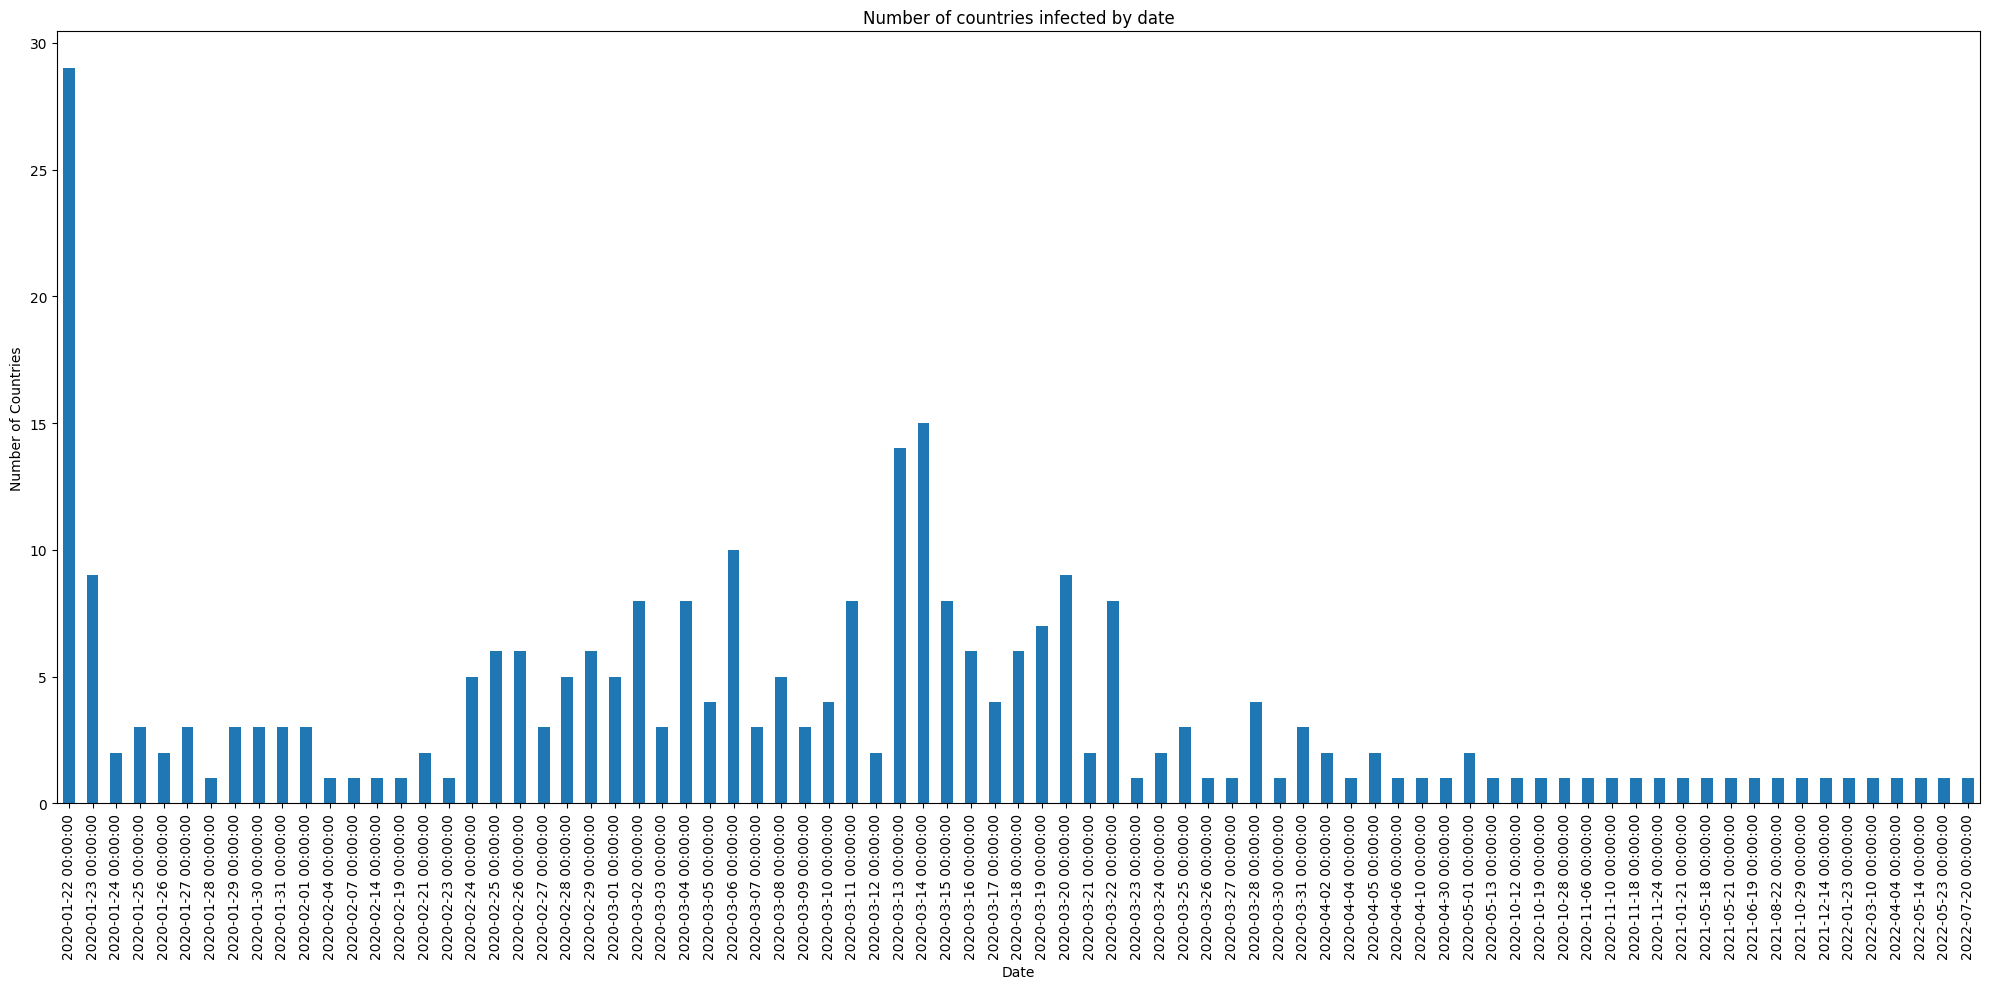

In [3]:
import matplotlib.pyplot as plt

csv_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)
    
# Convert the 5th column to datetime
df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')
    
# Count the occurrences of each date
date_counts = df.iloc[:, 4].value_counts().sort_index()
    
# Plot the histogram
plt.figure(figsize=(20, 10))
date_counts.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Number of Countries')
plt.title('Number of countries infected by date')
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Create Covid graph

In [4]:
import pandas as pd
# Sample data: DataFrame with columns 'Country' and 'FirstCaseDate'
csv_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)
    
# Convert the 5th column to datetime
df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')

print(df.columns)

Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'first_occurrence'], dtype='object')


# If Nan it probably means that there was no covid infection there (based on airports should be reported last?; provinces/states could be deleted?)

In [5]:
csv_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)

print(df[pd.isna(df['first_occurrence'])])

      Province/State  Country/Region      Lat    Long first_occurrence
288  Channel Islands  United Kingdom  49.3723 -2.3644              NaN


In [6]:
import networkx as nx
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from plotly.express import colors
from plotly.colors import sample_colorscale

# Sample data: DataFrame with columns 'Country' and 'FirstCaseDate'
csv_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)
    
# Convert the 5th column to datetime
#df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')

# Create a graph
G = nx.Graph()

# Add nodes
for _, row in df.iterrows():
    G.add_node(row['Country/Region'], province_state=row['Province/State'], first_case_date=row['first_occurrence'], Lat = row['Lat'], Long = row['Long'])



# Group countries by their first infection date and add edges between countries with the same date
grouped = df.groupby('first_occurrence')['Country/Region'].apply(list)
for date, countries in grouped.items():
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            G.add_edge(countries[i], countries[j], date=date)


# Generate a custom color palette with 81 distinct colors
unique_dates = df['first_occurrence'].unique()
num_colors = len(unique_dates)
color_scale = sample_colorscale('Viridis', [n / num_colors for n in range(num_colors)])

# Assign colors to each group (first case date)
color_map = {date: color_scale[i % num_colors] for i, date in enumerate(unique_dates)}


# Plot the graph
# Create node trace for scattergeo
node_trace = go.Scattergeo(
    lon=[G.nodes[node]['Long'] for node in G.nodes],
    lat=[G.nodes[node]['Lat'] for node in G.nodes],
    text=[f"{node}<br>First Case: {G.nodes[node]['first_case_date']}<br>Province or state: {G.nodes[node]['province_state']}" for node in G.nodes], #.date()
    mode='markers',
    marker=dict(
        size=[1 for node in G.nodes],
        color=[color_map[G.nodes[node]['first_case_date']] for node in G.nodes],
        opacity=0.7,
        colorscale='Viridis',
        colorbar=dict(title='First Case Date')
    )
)

"""
node_trace = go.Scattergeo(
    lon=[G.nodes[node]['Long'] for node in G.nodes],
    lat=[G.nodes[node]['Lat'] for node in G.nodes],
    text=[f"{node}<br>First Case: {G.nodes[node]['first_case_date'].date()}<br>Province or state: {G.nodes[node]['province_state']}" for node in G.nodes],
    mode='markers+text',
    marker=dict(size=[1 for node in G.nodes], color='blue', opacity=0.7),
    textposition="top center"
)
"""

# Create edge traces
edge_traces = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['Long'], G.nodes[edge[0]]['Lat']
    x1, y1 = G.nodes[edge[1]]['Long'], G.nodes[edge[1]]['Lat']
    #print(edge('date'))
    edge_color = color_map[G.nodes[edge[0]]['first_case_date']]
    edge_trace = go.Scattergeo(
        lon=[x0, x1, None],
        lat=[y0, y1, None],
        mode='lines',
        line=dict(width=0.5, color=edge_color),#dict(width=0.5, color='gray'),
        opacity=0.5
    )
    edge_traces.append(edge_trace)

# Create the figure
fig = go.Figure(data=edge_traces + [node_trace])

fig.update_layout(
    title='COVID-19 First Case Connections on World Map',
    showlegend=False,
    geo=dict(
        scope='world',
        projection_type='equirectangular',
        showland=True,
        landcolor='rgb(217, 217, 217)',
        subunitwidth=1,
        countrywidth=1,
        subunitcolor="rgb(255, 255, 255)",
        countrycolor="rgb(255, 255, 255)"
    )
)

fig.show()

In [7]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from plotly.colors import sample_colorscale

# Use the correct renderer for your environment
#pio.renderers.default = 'notebook'  # Use 'notebook' for Jupyter Notebook, 'browser' for others

csv_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)

df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')

df = df.dropna(subset=['first_occurrence'])

# Generate a custom color palette with 81 distinct colors
unique_dates = df['first_occurrence'].unique()
num_colors = len(unique_dates)
color_scale = sample_colorscale('Viridis', [n / num_colors for n in range(num_colors)])

# Assign colors to each group (first case date)
color_map = {date: color_scale[i % num_colors] for i, date in enumerate(unique_dates)}


# Create a scatter plot for nodes
node_trace = go.Scattergeo(
    lon=df['Long'],
    lat=df['Lat'],
    text=[f"{country}<br>First Case: {first_case}<br>Province or state: {provState}" for country, first_case, provState in zip(df['Country/Region'], df['first_occurrence'], df['Province/State'])],
    mode='markers',
    marker=dict(
        size=[(max(unique_dates) - first_case).days / 100 for first_case in df['first_occurrence']],  # Adjust size based on date difference
        color=[color_map[first_case] for first_case in df['first_occurrence']],
        opacity=0.7,
        colorscale='Viridis',
        colorbar=dict(title='First Case Date')
    )
)

# Create layout
layout = go.Layout(
    title='COVID-19 First Case Distribution',
    geo=dict(
        scope='world',
        projection_type='equirectangular',
        showland=True,
        landcolor='rgb(217, 217, 217)',
        subunitwidth=1,
        countrywidth=1,
        subunitcolor="rgb(255, 255, 255)",
        countrycolor="rgb(255, 255, 255)"
    )
)

# Create the figure
fig = go.Figure(data=node_trace, layout=layout)

# Show the figure
fig.show()

---

## Airport data (Create graph out of airports and routes)

In [8]:
import pandas as pd
import numpy as np
import igraph as ig
import pickle
import pycountry
import os
import matplotlib.pyplot as plt

In [9]:
airports_df = pd.read_csv('./data/airports.csv', sep=',', engine='python')
airports_df.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [10]:
routes_df = pd.read_csv('./data/routes.csv', sep=',', engine='python')
routes_df.head()

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


### Keep only EU countries (only if needed)

In [11]:
def is_eu(country_name):
    try:
        country = pycountry.countries.lookup(country_name)
        return country.alpha_2 in ('AD', 'AL', 'AM', 'AT', 'AZ', 'BA', 'BE', 'BG', 'BY', 'CH', 'CY', 'CZ', 
                                   'DE', 'DK', 'EE', 'ES', 'FI', 'FO', 'FR', 'GB', 'GE', 'GI', 'GR', 'HR', 
                                   'HU', 'IE', 'IS', 'IT', 'KZ', 'LI', 'LT', 'LU', 'LV', 'MC', 'MD', 'ME', 
                                   'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'RU', 'SE', 'SI', 'SK', 
                                   'SM', 'TR', 'UA', 'VA')
    except:
        return False

In [12]:
# airports_df = airports_df[[is_eu(r['Country']) for _, r in airports_df.iterrows()]]
# airports_df = airports_df.reset_index(drop=True)
# airports_df.head()

### Create graph

In [13]:
# infected_dataframe = pd.read_csv('data/covidUnitedCountries.csv')
# create_new_dataframe_with_first_non_zero_column('data/covidUnitedCountries.csv', 'data/covidUnitedCountriesFirstAppearance.csv')
first_infected_dataframe = pd.read_csv('data/covidUnitedCountriesFirstAppearance.csv')

infected_dict = dict()

graph = ig.Graph(directed=True)
id2index_map = {}
append_ctr = 0
for index, row in airports_df.iterrows():
    try:
        first_infected_ctry_date = first_infected_dataframe[first_infected_dataframe['Country/Region'] == row['Country']]['first_occurrence'].iloc[0]
    except IndexError as e:
        continue
    id2index_map[row['Airport ID']] = append_ctr
    append_ctr += 1
    if first_infected_ctry_date not in infected_dict:
        infected_dict[first_infected_ctry_date] = []
    infected_dict[first_infected_ctry_date].append(row['Airport ID'])
    graph.add_vertex(name=row['Name'], ID=row['Airport ID'], lat=row['Latitude'], lon=row['Longitude'], first_infected=first_infected_ctry_date)
    
    

In [14]:
edges = []
for index, row in routes_df.iterrows():
    if not row['Source airport ID'].strip().isdigit() or not row['Destination airport ID'].strip().isdigit():
        print("not an number:", row['Source airport ID'].strip().isdigit(), row['Destination airport ID'].strip().isdigit())
        continue
    
    aid = int(row['Source airport ID'])
    aid2 = int(row['Destination airport ID'])
    if 1328 in (aid, aid2):
        print(aid, aid2)
        
    if aid not in id2index_map or aid2 not in id2index_map:
        print("dont exist:", aid, aid2)
        continue
        
    edges.append((id2index_map[aid], id2index_map[aid2]))

graph.add_edges(edges)

not an number: True False
not an number: False True
not an number: True False
not an number: False True
dont exist: 3531 7167
dont exist: 3531 7168
dont exist: 3531 7162
dont exist: 3531 7164
dont exist: 3531 7163
dont exist: 7167 7176
dont exist: 7168 7173
dont exist: 7162 7161
dont exist: 7164 7165
dont exist: 7173 7172
dont exist: 5726 3830
dont exist: 5726 3678
dont exist: 4042 3830
dont exist: 4042 3678
dont exist: 3591 3678
dont exist: 3830 5726
dont exist: 3830 4042
dont exist: 3678 5726
dont exist: 3678 4042
dont exist: 3678 3591
dont exist: 7144 7145
dont exist: 7144 3808
dont exist: 7145 7144
dont exist: 7145 7147
dont exist: 7145 3808
dont exist: 7147 7145
dont exist: 7147 3808
dont exist: 3808 7144
dont exist: 3808 7145
dont exist: 3808 7147
dont exist: 3808 7146
dont exist: 7146 3808
dont exist: 3077 3316
dont exist: 3992 2276
dont exist: 3316 3077
dont exist: 3316 2276
dont exist: 2276 3992
dont exist: 2276 3316
dont exist: 3682 6958
dont exist: 3682 3754
dont exist: 3682

In [15]:
f'Nodes: {graph.vcount()}, Edges: {graph.ecount()}'

'Nodes: 5998, Edges: 48682'

### Delete zero degree nodes (cant make predictions if airport has no connections)

In [16]:
nodes_with_degree_zero = [vertex for vertex, degree in enumerate(graph.degree()) if degree == 0]
graph.delete_vertices(nodes_with_degree_zero)
len(nodes_with_degree_zero)

3446

In [17]:
f'Nodes: {graph.vcount()}, Edges: {graph.ecount()}'

'Nodes: 2552, Edges: 48682'

### Keep only largest connected component

In [18]:
sccs = graph.connected_components(mode='weak')
print(len(sccs))


# Get the sizes of each component
component_sizes = sccs.sizes()

for index in range(len(sccs)):
    print("Component:", index, "size:", component_sizes[index])


lcc = sccs.giant()
g = lcc

for element in g.vs:
    if first_infected_ctry_date not in infected_dict:
        infected_dict[first_infected_ctry_date] = []
    infected_dict[first_infected_ctry_date].append(element['ID'])

f'Nodes: {g.vcount()}, Edges: {g.ecount()}'


4
Component: 0 size: 2544
Component: 1 size: 2
Component: 2 size: 2
Component: 3 size: 4


'Nodes: 2544, Edges: 48670'

### Change to directed graph since multigraph doesnt add value (allready connected)

In [19]:
from igraph import Graph


# Initialize a new directed graph
digraph = Graph(directed=True)
for v in g.vs:
    digraph.add_vertex(**v.attributes())

# Add edges to the new graph, avoiding duplicates
existing_edges = set()
for edge in g.es:
    source = edge.source
    target = edge.target
    if (source, target) not in existing_edges:
        digraph.add_edge(source, target)
        existing_edges.add((source, target))



f'Nodes: {digraph.vcount()}, Edges: {digraph.ecount()}'

#for node in digraph.vs:
#    print(node['lat'])

#print(g["lat"])

g = digraph


### Save graph

In [20]:
with open("./data/graphWorld.pickle", "wb") as f:
    pickle.dump(g, f)

### Draw on world map (Not sure if good visualization)

In [21]:
import pickle

with open("./data/graphWorld.pickle", "rb") as f:
    g = pickle.load(f)
    
g.vcount(), g.ecount(), g.is_directed()

(2544, 27930, True)

In [22]:
lats, lons, sizes = [], [], []
for node in g.vs:
    lats.append(node['lat'])
    lons.append(node['lon'])
    sizes.append(g.degree(node) / 5)

/var/folders/8d/0bd47wg9327_3csn3fn91fk00000gn/T/ipykernel_3290/3270528285.py:7: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



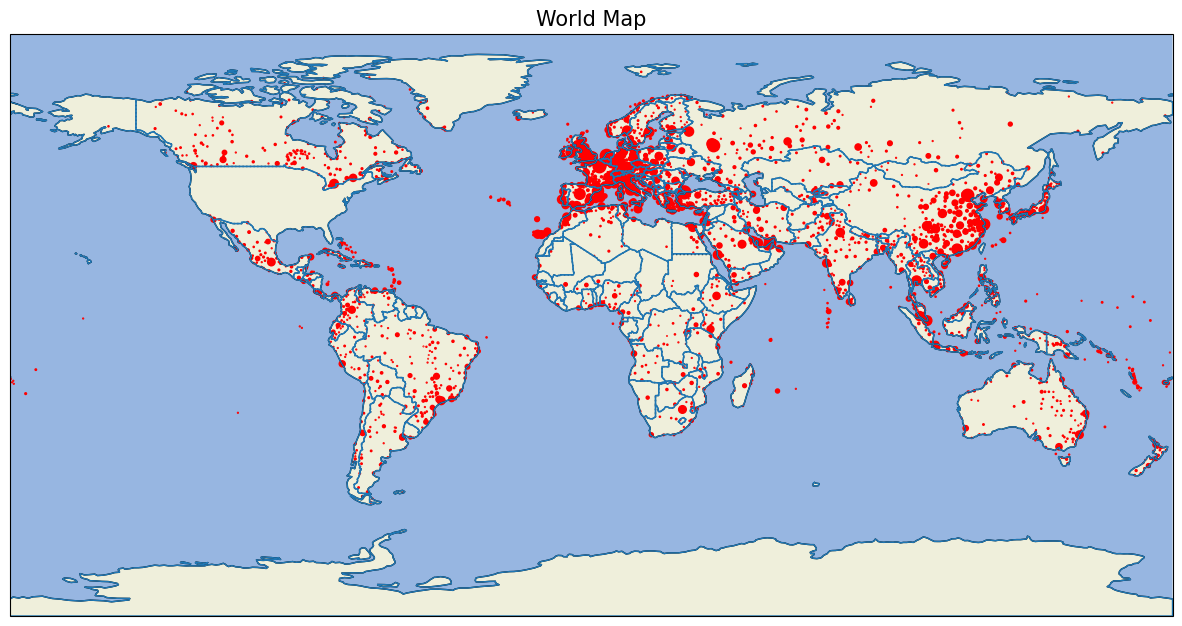

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the world map from geopandas datasets
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a figure and axis using cartopy with a specific projection
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add geographical features using cartopy
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the world map
world.boundary.plot(ax=ax, linewidth=1)

# Add a title
ax.set_title('World Map', fontsize=15)

ax.scatter(lons, lats, s=sizes, color='red', transform=ccrs.PlateCarree())

# Display the plot
plt.show()

---

## Perform node importance analysis

In [24]:
import networkx as nx
import utils

import igraph as ig
import networkx as nx


G = g.to_networkx()

G = nx.convert_node_labels_to_integers(G, label_attribute=None)

#G = nx.DiGraph(G)

print(G)

DiGraph with 2544 nodes and 27930 edges


In [25]:
print(G.nodes[0])

{'ID': 1, 'lat': -6.0816898345900015, 'lon': 145.391998291, 'first_infected': '3/20/20', 'name': 'Goroka Airport', '_igraph_index': 0}


### Degree Centrality

In [26]:
from importlib import reload
reload(utils)

top_degree = utils.top_nodes(G, nx.degree_centrality(G), 'degree')

  Centrality | 'degree'
    0.171058 | 'Atatürk International Airport' (In-deg:219, Out-deg:216), ID:761
    0.169485 | 'Frankfurt am Main Airport' (In-deg:215, Out-deg:216), ID:191
    0.164373 | 'Amsterdam Airport Schiphol' (In-deg:209, Out-deg:209), ID:282
    0.163193 | 'Charles de Gaulle International Airport' (In-deg:207, Out-deg:208), ID:620
    0.148643 | 'Beijing Capital International Airport' (In-deg:189, Out-deg:189), ID:1558
    0.145104 | 'Domodedovo International Airport' (In-deg:185, Out-deg:184), ID:1669
    0.139206 | 'Munich Airport' (In-deg:176, Out-deg:178), ID:196
    0.132914 | 'Dubai International Airport' (In-deg:166, Out-deg:172), ID:968
    0.125049 | 'London Gatwick Airport' (In-deg:159, Out-deg:159), ID:253
    0.125049 | 'Barcelona International Airport' (In-deg:159, Out-deg:159), ID:562
    0.119937 | 'London Stansted Airport' (In-deg:152, Out-deg:153), ID:279
    0.116398 | 'Adolfo Suárez Madrid–Barajas Airport' (In-deg:147, Out-deg:149), ID:570
    0.114

### In-degree centrality

In [27]:
from importlib import reload
reload(utils)

top_degree = utils.top_nodes(G, nx.in_degree_centrality(G), 'degree')

  Centrality | 'degree'
    0.086119 | 'Atatürk International Airport' (In-deg:219, Out-deg:216), ID:761
    0.084546 | 'Frankfurt am Main Airport' (In-deg:215, Out-deg:216), ID:191
    0.082186 | 'Amsterdam Airport Schiphol' (In-deg:209, Out-deg:209), ID:282
    0.081400 | 'Charles de Gaulle International Airport' (In-deg:207, Out-deg:208), ID:620
    0.074322 | 'Beijing Capital International Airport' (In-deg:189, Out-deg:189), ID:1558
    0.072749 | 'Domodedovo International Airport' (In-deg:185, Out-deg:184), ID:1669
    0.069210 | 'Munich Airport' (In-deg:176, Out-deg:178), ID:196
    0.065277 | 'Dubai International Airport' (In-deg:166, Out-deg:172), ID:968
    0.062525 | 'London Gatwick Airport' (In-deg:159, Out-deg:159), ID:253
    0.062525 | 'Barcelona International Airport' (In-deg:159, Out-deg:159), ID:562
    0.059772 | 'London Stansted Airport' (In-deg:152, Out-deg:153), ID:279
    0.057806 | 'Adolfo Suárez Madrid–Barajas Airport' (In-deg:147, Out-deg:149), ID:570
    0.057

### Out-degree centrality

In [28]:
from importlib import reload
reload(utils)

top_degree = utils.top_nodes(G, nx.out_degree_centrality(G), 'degree')

  Centrality | 'degree'
    0.084939 | 'Atatürk International Airport' (In-deg:219, Out-deg:216), ID:761
    0.084939 | 'Frankfurt am Main Airport' (In-deg:215, Out-deg:216), ID:191
    0.082186 | 'Amsterdam Airport Schiphol' (In-deg:209, Out-deg:209), ID:282
    0.081793 | 'Charles de Gaulle International Airport' (In-deg:207, Out-deg:208), ID:620
    0.074322 | 'Beijing Capital International Airport' (In-deg:189, Out-deg:189), ID:1558
    0.072355 | 'Domodedovo International Airport' (In-deg:185, Out-deg:184), ID:1669
    0.069996 | 'Munich Airport' (In-deg:176, Out-deg:178), ID:196
    0.067637 | 'Dubai International Airport' (In-deg:166, Out-deg:172), ID:968
    0.062525 | 'London Gatwick Airport' (In-deg:159, Out-deg:159), ID:253
    0.062525 | 'Barcelona International Airport' (In-deg:159, Out-deg:159), ID:562
    0.060165 | 'London Stansted Airport' (In-deg:152, Out-deg:153), ID:279
    0.058592 | 'Adolfo Suárez Madrid–Barajas Airport' (In-deg:147, Out-deg:149), ID:570
    0.057

### Clustering Coefficients

In [29]:
top_clustering = utils.top_nodes(G, nx.clustering(G), 'clustering')

  Centrality | 'clustering'
    1.000000 | 'Tabuk Airport' (In-deg:7, Out-deg:7), ID:936
    1.000000 | 'Abraham González International Airport' (In-deg:6, Out-deg:6), ID:800
    1.000000 | 'Qianjiang Wulingshan Airport' (In-deg:6, Out-deg:6), ID:2482
    1.000000 | 'Regina International Airport' (In-deg:5, Out-deg:5), ID:72
    1.000000 | 'Saskatoon John G. Diefenbaker International Airport' (In-deg:5, Out-deg:5), ID:102
    1.000000 | 'Victoria International Airport' (In-deg:5, Out-deg:5), ID:119
    1.000000 | 'Angel Albino Corzo International Airport' (In-deg:5, Out-deg:5), ID:835
    1.000000 | 'Queenstown International Airport' (In-deg:6, Out-deg:4), ID:904
    1.000000 | 'Ernesto Cortissoz International Airport' (In-deg:5, Out-deg:5), ID:1204
    1.000000 | 'Rafael Nuñez International Airport' (In-deg:5, Out-deg:5), ID:1208
    1.000000 | 'Bintulu Airport' (In-deg:5, Out-deg:5), ID:1496
    1.000000 | 'Jiuzhai Huanglong Airport' (In-deg:5, Out-deg:5), ID:1762
    1.000000 | 'Ass

### mu-corrected clustering coefficient

In [30]:
top_mu_clustering = utils.top_nodes(G, {i: c * (G.degree(i) - 1) for i, c in nx.clustering(G).items()}, '~μ-clustering')

  Centrality | '~μ-clustering'
   74.776769 | 'Barcelona International Airport' (In-deg:159, Out-deg:159), ID:562
   74.565574 | 'Zürich Airport' (In-deg:122, Out-deg:123), ID:749
   74.543666 | 'Leonardo da Vinci–Fiumicino Airport' (In-deg:147, Out-deg:145), ID:697
   73.744451 | 'Munich Airport' (In-deg:176, Out-deg:178), ID:196
   73.214510 | 'Dublin Airport' (In-deg:134, Out-deg:134), ID:288
   72.701031 | 'Geneva Cointrin International Airport' (In-deg:97, Out-deg:98), ID:746
   72.048765 | 'Amsterdam Airport Schiphol' (In-deg:209, Out-deg:209), ID:282
   69.820275 | 'Copenhagen Kastrup Airport' (In-deg:113, Out-deg:114), ID:295
   69.734615 | 'Václav Havel Airport Prague' (In-deg:94, Out-deg:94), ID:707
   68.725829 | 'Malpensa International Airport' (In-deg:107, Out-deg:103), ID:682
   68.546651 | 'Brussels Airport' (In-deg:141, Out-deg:140), ID:184
   68.384401 | 'Vienna International Airport' (In-deg:133, Out-deg:132), ID:719
   67.323940 | 'Hamburg Airport' (In-deg:86, Out-de

### Eigenvector Centrality

In [31]:
def eigenvector_centrality(G, eps = 1e-6):
    # Initialize eigenvector centrality score
    E = [1] * G.number_of_nodes()
    diff = 1
    # Repeat until the change in scores is less than a small value 'eps'
    while diff > eps:
        # Update scores based on neighbors' scores
        U = [sum([E[j] for j in G[i]]) for i in G.nodes()]
        # Normalize scores
        u = sum(U)
        U = [U[i] * len(G) / u for i in G.nodes()]
        # Calculate change in scores
        diff = sum([abs(E[i] - U[i]) for i in G.nodes()])
        # Use the new scores for the next iteration
        E = U
    return {i: E[i] for i in range(len(E))}

top_eigenVect = utils.top_nodes(G, eigenvector_centrality(G), 'eigenvector')

  Centrality | 'eigenvector'
   23.966808 | 'Amsterdam Airport Schiphol' (In-deg:209, Out-deg:209), ID:282
   23.591270 | 'Frankfurt am Main Airport' (In-deg:215, Out-deg:216), ID:191
   22.557235 | 'Charles de Gaulle International Airport' (In-deg:207, Out-deg:208), ID:620
   22.521835 | 'Munich Airport' (In-deg:176, Out-deg:178), ID:196
   20.875948 | 'Barcelona International Airport' (In-deg:159, Out-deg:159), ID:562
   20.078374 | 'Leonardo da Vinci–Fiumicino Airport' (In-deg:147, Out-deg:145), ID:697
   19.739303 | 'Atatürk International Airport' (In-deg:219, Out-deg:216), ID:761
   19.028083 | 'Brussels Airport' (In-deg:141, Out-deg:140), ID:184
   18.664945 | 'London Gatwick Airport' (In-deg:159, Out-deg:159), ID:253
   18.577645 | 'Zürich Airport' (In-deg:122, Out-deg:123), ID:749
   18.450751 | 'Adolfo Suárez Madrid–Barajas Airport' (In-deg:147, Out-deg:149), ID:570
   18.386464 | 'London Heathrow Airport' (In-deg:145, Out-deg:145), ID:255
   18.073203 | 'Dublin Airport' (In-d

In [32]:
top_eigenVect = utils.top_nodes(G, nx.eigenvector_centrality(G), 'eigenvector')

  Centrality | 'eigenvector'
    0.167878 | 'Amsterdam Airport Schiphol' (In-deg:209, Out-deg:209), ID:282
    0.163380 | 'Frankfurt am Main Airport' (In-deg:215, Out-deg:216), ID:191
    0.156556 | 'Charles de Gaulle International Airport' (In-deg:207, Out-deg:208), ID:620
    0.156101 | 'Munich Airport' (In-deg:176, Out-deg:178), ID:196
    0.145163 | 'Barcelona International Airport' (In-deg:159, Out-deg:159), ID:562
    0.140356 | 'Leonardo da Vinci–Fiumicino Airport' (In-deg:147, Out-deg:145), ID:697
    0.138462 | 'Atatürk International Airport' (In-deg:219, Out-deg:216), ID:761
    0.133255 | 'Brussels Airport' (In-deg:141, Out-deg:140), ID:184
    0.129618 | 'London Gatwick Airport' (In-deg:159, Out-deg:159), ID:253
    0.128494 | 'Zürich Airport' (In-deg:122, Out-deg:123), ID:749
    0.128052 | 'London Heathrow Airport' (In-deg:145, Out-deg:145), ID:255
    0.127767 | 'Adolfo Suárez Madrid–Barajas Airport' (In-deg:147, Out-deg:149), ID:570
    0.126208 | 'Vienna International 

### PageRank

In [33]:
def pagerank(G, alpha = 0.85, eps = 1e-6):
    P = [1 / len(G)] * len(G)
    diff = 1
    # Repeat until the change in scores is less than a small value 'eps'
    while diff > eps:
        # Update scores based on neighbors' scores and the number of their out-links
        U = [sum([P[j] * alpha / G.degree(j) for j in G[i]]) for i in G.nodes()]
        # Calculate a damping factor based on the 'alpha' parameter
        u = sum(U)
        # Apply the damping factor and ensure that the scores sum up to 1
        U = [U[i] + (1 - u) / len(G) for i in G.nodes()]
        # Calculate change in scores
        diff = sum([abs(P[i] - U[i]) for i in G.nodes()])
        P = U
    return {i: P[i] for i in range(len(P))}

top_pagerank = utils.top_nodes(G, pagerank(G), 'pagerank')

  Centrality | 'pagerank'
    0.004060 | 'Domodedovo International Airport' (In-deg:185, Out-deg:184), ID:1669
    0.003322 | 'El Dorado International Airport' (In-deg:62, Out-deg:62), ID:1203
    0.003297 | 'Atatürk International Airport' (In-deg:219, Out-deg:216), ID:761
    0.003037 | 'Licenciado Benito Juarez International Airport' (In-deg:73, Out-deg:72), ID:819
    0.002850 | 'Jorge Newbery Airpark' (In-deg:42, Out-deg:43), ID:1071
    0.002847 | 'Tokyo Haneda International Airport' (In-deg:67, Out-deg:67), ID:1041
    0.002844 | 'Sydney Kingsford Smith International Airport' (In-deg:75, Out-deg:76), ID:1555
    0.002765 | 'Ninoy Aquino International Airport' (In-deg:70, Out-deg:70), ID:1054
    0.002600 | 'Beijing Capital International Airport' (In-deg:189, Out-deg:189), ID:1558
    0.002462 | 'OR Tambo International Airport' (In-deg:77, Out-deg:76), ID:381
    0.002230 | 'Dubai International Airport' (In-deg:166, Out-deg:172), ID:968
    0.002185 | 'Indira Gandhi International 

In [34]:
top_pagerank = utils.top_nodes(G, nx.pagerank(G), 'pagerank')

  Centrality | 'pagerank'
    0.005633 | 'Atatürk International Airport' (In-deg:219, Out-deg:216), ID:761
    0.005366 | 'Domodedovo International Airport' (In-deg:185, Out-deg:184), ID:1669
    0.004892 | 'Charles de Gaulle International Airport' (In-deg:207, Out-deg:208), ID:620
    0.004892 | 'Frankfurt am Main Airport' (In-deg:215, Out-deg:216), ID:191
    0.004881 | 'Beijing Capital International Airport' (In-deg:189, Out-deg:189), ID:1558
    0.004574 | 'Amsterdam Airport Schiphol' (In-deg:209, Out-deg:209), ID:282
    0.004539 | 'Dubai International Airport' (In-deg:166, Out-deg:172), ID:968
    0.004282 | 'El Dorado International Airport' (In-deg:62, Out-deg:62), ID:1203
    0.004133 | 'Sydney Kingsford Smith International Airport' (In-deg:75, Out-deg:76), ID:1555
    0.003909 | 'Licenciado Benito Juarez International Airport' (In-deg:73, Out-deg:72), ID:819
    0.003821 | 'Singapore Changi Airport' (In-deg:119, Out-deg:119), ID:1525
    0.003698 | 'Guangzhou Baiyun Internatio

### Closeness Centrality (probably not good for weak graph since it calculates distances for all nodes to all other nodes)

In [35]:
top_closeness = utils.top_nodes(G, nx.closeness_centrality(G), 'closeness')

  Centrality | 'closeness'
    0.411398 | 'Frankfurt am Main Airport' (In-deg:215, Out-deg:216), ID:191
    0.408730 | 'Charles de Gaulle International Airport' (In-deg:207, Out-deg:208), ID:620
    0.404663 | 'London Heathrow Airport' (In-deg:145, Out-deg:145), ID:255
    0.403561 | 'Dubai International Airport' (In-deg:166, Out-deg:172), ID:968
    0.401249 | 'Amsterdam Airport Schiphol' (In-deg:209, Out-deg:209), ID:282
    0.393606 | 'Atatürk International Airport' (In-deg:219, Out-deg:216), ID:761
    0.389351 | 'Munich Airport' (In-deg:176, Out-deg:178), ID:196
    0.387734 | 'Hamad International Airport' (In-deg:111, Out-deg:109), ID:2534
    0.385422 | 'Leonardo da Vinci–Fiumicino Airport' (In-deg:147, Out-deg:145), ID:697
    0.384306 | 'Beijing Capital International Airport' (In-deg:189, Out-deg:189), ID:1558
    0.382035 | 'Suvarnabhumi Airport' (In-deg:116, Out-deg:116), ID:1599
    0.379219 | 'Lester B. Pearson International Airport' (In-deg:95, Out-deg:96), ID:125
    0.3

### Betweenness Centrality

In [36]:
nodesBetweenness = utils.top_nodes(G, nx.betweenness_centrality(G), 'betweenness')#, n=len(G))

  Centrality | 'betweenness'
    0.078791 | 'Charles de Gaulle International Airport' (In-deg:207, Out-deg:208), ID:620
    0.077057 | 'Dubai International Airport' (In-deg:166, Out-deg:172), ID:968
    0.071469 | 'Lester B. Pearson International Airport' (In-deg:95, Out-deg:96), ID:125
    0.068772 | 'Frankfurt am Main Airport' (In-deg:215, Out-deg:216), ID:191
    0.060376 | 'Beijing Capital International Airport' (In-deg:189, Out-deg:189), ID:1558
    0.056161 | 'Guarulhos - Governador André Franco Montoro International Airport' (In-deg:78, Out-deg:80), ID:1129
    0.054655 | 'Amsterdam Airport Schiphol' (In-deg:209, Out-deg:209), ID:282
    0.053089 | 'Atatürk International Airport' (In-deg:219, Out-deg:216), ID:761
    0.051416 | 'Singapore Changi Airport' (In-deg:119, Out-deg:119), ID:1525
    0.050814 | 'London Heathrow Airport' (In-deg:145, Out-deg:145), ID:255
    0.046968 | 'Sydney Kingsford Smith International Airport' (In-deg:75, Out-deg:76), ID:1555
    0.040714 | 'Adolfo 

### Testing node order by degree (in-degree probably more important since youre interested in Covid coming in; But other ppl could travel to an airport by car (in) to continue by plane (out))

In [37]:
degrees = dict(G.degree())

# Sort nodes by degree (in descending order)
sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)

# Print sorted nodes and their degrees
for node in sorted_nodes[:15]:
    print(f"ID:{node}, Name:{G.nodes[node]['name']}  - Degree: {degrees[node]}")

ID:761, Name:Atatürk International Airport  - Degree: 435
ID:191, Name:Frankfurt am Main Airport  - Degree: 431
ID:282, Name:Amsterdam Airport Schiphol  - Degree: 418
ID:620, Name:Charles de Gaulle International Airport  - Degree: 415
ID:1558, Name:Beijing Capital International Airport  - Degree: 378
ID:1669, Name:Domodedovo International Airport  - Degree: 369
ID:196, Name:Munich Airport  - Degree: 354
ID:968, Name:Dubai International Airport  - Degree: 338
ID:253, Name:London Gatwick Airport  - Degree: 318
ID:562, Name:Barcelona International Airport  - Degree: 318
ID:279, Name:London Stansted Airport  - Degree: 305
ID:570, Name:Adolfo Suárez Madrid–Barajas Airport  - Degree: 296
ID:697, Name:Leonardo da Vinci–Fiumicino Airport  - Degree: 292
ID:255, Name:London Heathrow Airport  - Degree: 290
ID:184, Name:Brussels Airport  - Degree: 281


In [38]:
degrees = dict(G.in_degree())

# Sort nodes by degree (in descending order)
sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)

# Print sorted nodes and their degrees
for node in sorted_nodes[:15]:
    print(f"ID:{node}, Name:{G.nodes[node]['name']}  - Degree: {degrees[node]}")

ID:761, Name:Atatürk International Airport  - Degree: 219
ID:191, Name:Frankfurt am Main Airport  - Degree: 215
ID:282, Name:Amsterdam Airport Schiphol  - Degree: 209
ID:620, Name:Charles de Gaulle International Airport  - Degree: 207
ID:1558, Name:Beijing Capital International Airport  - Degree: 189
ID:1669, Name:Domodedovo International Airport  - Degree: 185
ID:196, Name:Munich Airport  - Degree: 176
ID:968, Name:Dubai International Airport  - Degree: 166
ID:253, Name:London Gatwick Airport  - Degree: 159
ID:562, Name:Barcelona International Airport  - Degree: 159
ID:279, Name:London Stansted Airport  - Degree: 152
ID:570, Name:Adolfo Suárez Madrid–Barajas Airport  - Degree: 147
ID:697, Name:Leonardo da Vinci–Fiumicino Airport  - Degree: 147
ID:255, Name:London Heathrow Airport  - Degree: 145
ID:184, Name:Brussels Airport  - Degree: 141


In [39]:
degrees = dict(G.out_degree())

# Sort nodes by degree (in descending order)
sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)

# Print sorted nodes and their degrees
for node in sorted_nodes[:15]:
    print(f"ID:{node}, Name:{G.nodes[node]['name']}  - Degree: {degrees[node]}")

ID:191, Name:Frankfurt am Main Airport  - Degree: 216
ID:761, Name:Atatürk International Airport  - Degree: 216
ID:282, Name:Amsterdam Airport Schiphol  - Degree: 209
ID:620, Name:Charles de Gaulle International Airport  - Degree: 208
ID:1558, Name:Beijing Capital International Airport  - Degree: 189
ID:1669, Name:Domodedovo International Airport  - Degree: 184
ID:196, Name:Munich Airport  - Degree: 178
ID:968, Name:Dubai International Airport  - Degree: 172
ID:253, Name:London Gatwick Airport  - Degree: 159
ID:562, Name:Barcelona International Airport  - Degree: 159
ID:279, Name:London Stansted Airport  - Degree: 153
ID:570, Name:Adolfo Suárez Madrid–Barajas Airport  - Degree: 149
ID:255, Name:London Heathrow Airport  - Degree: 145
ID:697, Name:Leonardo da Vinci–Fiumicino Airport  - Degree: 145
ID:184, Name:Brussels Airport  - Degree: 140


### neki markdown naslov

In [40]:
# create networkx graph
first_infected_dataframe = pd.read_csv('data/covidUnitedCountriesFirstAppearance.csv')

graph = nx.DiGraph()
append_ctr = 0
for index, row in airports_df.iterrows():
    try:
        first_infected_ctry_date = first_infected_dataframe[first_infected_dataframe['Country/Region'] == row['Country']]['first_occurrence'].iloc[0]
    except IndexError as e:
        continue
    # id2index_map[row['Airport ID']] = append_ctr
    # append_ctr += 1
    graph.add_node(row['Airport ID'], name=row['Name'], IATA=row['IATA'], lat=row['Latitude'], lon=row['Longitude'], first_infected=first_infected_ctry_date)
    

In [41]:
edges = []
for index, row in routes_df.iterrows():
    if not row['Source airport ID'].strip().isdigit() or not row['Destination airport ID'].strip().isdigit():
        continue
    
    aid = int(row['Source airport ID'])
    aid2 = int(row['Destination airport ID'])
    if 1328 in (aid, aid2):
        print(aid, aid2)
        
    if aid not in id2index_map or aid2 not in id2index_map:
        continue
    graph.add_edge(aid, aid2)

print(graph)

DiGraph with 5998 nodes and 27942 edges


In [42]:
scc = list(nx.weakly_connected_components(graph))
G = graph.subgraph(max(scc, key=len)).copy()
print(G)

DiGraph with 2544 nodes and 27930 edges


In [43]:
infected_dict = dict()
for n in G.nodes:
    first_infected_ctry_date = G.nodes[n]['first_infected']
    if first_infected_ctry_date not in infected_dict:
        infected_dict[first_infected_ctry_date] = []
    infected_dict[first_infected_ctry_date].append(n)

In [46]:
import datetime
    
def retarded_date_to_datetime(date):
    return datetime.datetime.strptime(date, "%m/%d/%y").date()

def get_bipartite_from_graph(in_graph, date):
    bipart_graph = nx.Graph()
    date_datetime = retarded_date_to_datetime(date)
    party_a = set()
    party_b = set()
    connections = list()
    for key, airports in infected_dict.items():
        if retarded_date_to_datetime(key) <= date_datetime:
            for n in airports:# ej fora je da js mam kle airport Id.... kak loh zdej to konvertam v index?
                node_src = in_graph.nodes[n] # n je airport ID
                for t in in_graph.neighbors(n):
                    node = in_graph.nodes[t]
                    if retarded_date_to_datetime(node['first_infected']) < date_datetime:
                        pass # ignore nodes that have already been infected
                    else:
                        party_a.add(node_src['name'])
                        party_b.add(node['name'])
                        connections.append((node_src['name'], node['name']))
    bipart_graph.add_nodes_from(party_a, bipartite=0)
    bipart_graph.add_nodes_from(party_b, bipartite=1)
    bipart_graph.add_edges_from(connections)
    return bipart_graph
    

In [47]:

for date in ['1/22/20', '3/6/20']: # dates to be added
    t = get_bipartite_from_graph(G, date)
    print(t)
    pass sdfsdfsdf